In [2]:
#import necessary packages
!apt-get -qq install python-cartopy python3-cartopy
import cartopy
!pip install pykrige
import pandas as pd 
import matplotlib.pyplot as plt
import pylab #using as a plotting library for spatial data, make contours
import numpy as np #gridded datasets and matrices; array package


# import cartopy, which we will use to map
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import cartopy.io as cio



from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [19]:
!pip install pyproj
!pip install pyepsg

In [0]:
import pyproj #needs to be done in separate cell from !pip install pyproj
import pyepsg

In [0]:
df = pd.read_excel('https://github.com/mcampo26/map/blob/master/2002_pumping_V2.xls?raw=true') #read excel data

In [0]:
illimap= {'proj': 'lcc', # Lambert Conformal Conic
     'ellps': 'clrk66', #Clarke 1866 ellipsoid
     'lon_0': -89.5, #Central Meridian
     'lat_0': 33, #Latitude of Origin
     'lat_1': 33, #Standard Parallel 1
     'lat_2': 45, #Standard Parallel 2
     'x_0': 2999994*0.3048006096012192, #starting x-coord. in ft, python expects m
     'y_0': 0} #starting y-coord.

wgs84= pyproj.Proj('epsg:4326') #Standard lat/long coordinates

In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
downloaded = drive.CreateFile({'id':"1Q3u_9dBGIKAKss2dAzfQLGYlTPESpOaF"})   
downloaded.GetContentFile('county.shp')

downloaded = drive.CreateFile({'id':"17lPftwdyWfAQceGgdNAwUxH4KQQNiQlE"})   
downloaded.GetContentFile('county.dbf')

downloaded = drive.CreateFile({'id':"1gU4wh_K0tl7GQHgmZEeUOFi8iT4m0YEm"})   
downloaded.GetContentFile('county.shx')

downloaded = drive.CreateFile({'id':"1TYi6CJqO3Jt9Iyd2yWlnDhe-VnXYRo2G"})   
downloaded.GetContentFile('county.prj')

In [0]:
Latitude=[] #create empty latitude array that we will fill with converted latitude values
Longitude=[] #create empty longitude array that we will fill with converted longitude values
#write for loop where we convert lambert coordinates to wgs84 using illimap projection data
for index, row in df.iterrows(): 
  from pyproj import Proj, transform
  inProj = Proj(illimap) #define input projection
  outProj = wgs84 #define output projection
  Long1,Lat1 = (0.3048006096012192*row['lam_x'],0.3048006096012192*row['lam_y']) #define input coordinates; convert lambert ft to m
  Long2,Lat2 = transform(inProj,outProj,Long1,Lat1) #converts from lambert to wgs84
  Latitude.append(Lat2) #add latitude data to empty Latitude=[] array
  Longitude.append(Long2) #add longitude data to empty Longitude=[] array
df['Latitude']=Latitude #create latitude column in dataframe with converted latitude values
df['Longitude']=Longitude #create longitude column in dataframe with converted longitude values
df2002pump=df.drop(['lam_x','lam_y'],axis=1) #drop unnecessary columns; in this case lambert coordinates
df2002pump=df2002pump.rename(columns={"2002": "Pumpage 2002 (gal/yr)"}) #renaming column for clarification
pd.set_option("display.max_rows", None, "display.max_columns", None) #to display all data
#print(df2002pump)

In [0]:
#Domain of project
sw_lat = 41.411972 #southwest latitude
sw_long =  -88.241971 #southwest longitude
ne_lat =  41.72910 #northeast latitude
ne_long = -88.030337 #northeast longitude

In [0]:

minlat = 41.25 #minimum latitude for map extent
maxlat = 41.80 #maximum latitude for map extent
minlong = -88.25 #minimum longitude for map extent
maxlong = -88.0 #maximum longitude for map extent


<class 'list'>
<class 'cartopy.feature.NaturalEarthFeature'>


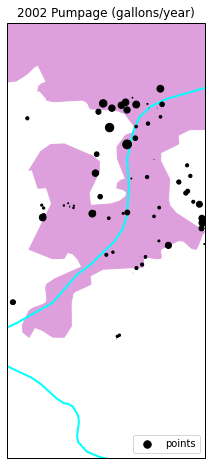

In [45]:
#plotting figure for pumpage data
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_xlim(minlong,maxlong)
ax.set_ylim(minlat,maxlat)
ax.set_title("Pumpage (gallons/yr)")
#add geographical features
#first defining state borders
states_provinces = cf.NaturalEarthFeature(
    category='cultural', # features are categorized as cultural or physical
    name='admin_1_states_provinces', # name of shapefile
    scale='50m', # scale of features
    facecolor='none')	
#second defining major rivers
largerivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines',
    scale='110m', # major rivers
    facecolor='none')
#third defining smaller rivers
smallrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_lake_centerlines_scale_rank',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
#third defining smaller rivers
smallestrivers = cf.NaturalEarthFeature(
    category='physical',
    name='rivers_north_america',
    scale='10m', # smaller rivers (still considered major by many/most people)
    facecolor='none')   
#fourth defining poplaces
popplaces = cf.NaturalEarthFeature(
    category='cultural',
    name='urban_areas', # plots municipal boundaries
    scale='10m',
    facecolor='plum') 

#countyshape = list(cio.shapereader.Reader('county.shp').geometries())

# adds the features defined above; zorder allows you to choose the order map is layered
ax.add_feature(popplaces,edgecolor='plum',linewidth=1.0, zorder=1)
ax.add_feature(largerivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(smallrivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(smallestrivers,edgecolor='aqua',linewidth=2.0, zorder=2)
ax.add_feature(states_provinces, edgecolor='slategray', linewidth=3.0,linestyle=':', zorder=3)
#ax.add_geometries(countyshape,ccrs.PlateCarree(),facecolor='red',edgecolor = 'red',linewidth=3.0)

#create array of pumpage data and adjust accordingly; divided by a number appropriate for map size by trial and error
#when you make scatter plot (below), this allows different sized points to be plotted, related to the magnitude of pumping 
sz=(df2002pump['Pumpage 2002 (gal/yr)'].values/1000000) 

#plot map of pumpage data with coordinates
plt.scatter(df2002pump['Latitude'],df2002pump['Longitude'],sz, marker=".", color="black", label="points",zorder=3)
plt.legend(loc='lower right')
plt.fill()
plt.title('2002 Pumpage (gallons/year)')
plt.show()

In [13]:
print(interstates)

[<shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14c860>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14c898>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14c9e8>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14ca90>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14cb38>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14cbe0>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14ccc0>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14cd30>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14cdd8>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14ce80>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a14cf28>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a15c048>, <shapely.geometry.multilinestring.MultiLineString object at 0x7f851a15c0b8>